In [37]:
#implementación para crear las nuevas imágenes

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


In [88]:
def read_listfile(path):
    archivos=os.listdir(path) #Lee todos los archivos pero no hace confimarción 
    #print(archivos)           
    return archivos


#función limpia los demas archivos y solod eja los .tif y los jpg de la lista, esto para no involucrar
# a los archivos de loc que carga el dron, en el caso de ser un algoritmo general. 
def limpieza_nombres(lista):
    lis_jpg_tif=[]
    lis_jpg=[]
    for nombres in lista:
            #hacemos filtro de la lista
            #if not in funciona como: Si no esta en la lista
            #El split(".") divide la palabra en el punto y toma desde la parte de atras
            # por el -1
            if nombres.split(".")[-1].upper() in ["jpg","JPG","TIF","tif"]:
                lis_jpg_tif.append(nombres)
            if nombres.split(".")[-1].upper() in ["jpg","JPG"]:
                lis_jpg.append(nombres)
    return lis_jpg_tif,lis_jpg #Lista con los nombrs de todos los archivos jpg y tif

def estabilizador_imagen(imagen_base, imagen_a_estabilizar, radio = 0.75, error_reproyeccion = 4.0, coincidencias = False):
        """Esta clase devuelve una secuencia de imágenes tomadas de la cámara estabilizada con respecto a la primera imagen"""
        
        # Se obtienen los puntos deinterés
        
        (kpsBase, featuresBase) = obtener_puntos_interes(imagen_base)
        (kpsAdicional, featuresAdicional) = obtener_puntos_interes(imagen_a_estabilizar)
        # Se buscan las coincidencias        
        
        M = encontrar_coincidencias(imagen_base, imagen_a_estabilizar, kpsBase, kpsAdicional, featuresBase, featuresAdicional, radio)
        
        if M is None:
            print("pocas coincidencias")
            return None
        
        if len(M) > 4:
            # construct the two sets of points
            # M2 = cv2.getPerspectiveTransform(ptsA,ptsB)
            (H, status) = encontrar_H_RANSAC_Estable(M, kpsBase, kpsAdicional, error_reproyeccion)
            estabilizada = cv2.warpPerspective(imagen_base,H,(imagen_base.shape[1],imagen_base.shape[0]))
            return estabilizada
        print("sin coincidencias")
        return None


# alineación de imágenes



#--------------------------------------------------------------------------
def obtener_puntos_interes(imagen):
    f =cv2.SIFT_create()
    (kps, features) =f.detectAndCompute(imagen, None)
    return kps, features

def encontrar_coincidencias(img1, img2, kpsA, kpsB, featuresA, featuresB, ratio):
        """Metodo para estimar la homografia"""
        
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []
#        
#        # loop over the raw matches
        for m in rawMatches:
#            # ensure the distance is within a certain ratio of each
#            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
        
#        print (matches)
        return matches
    
def encontrar_H_RANSAC_Estable( matches, kpsA, kpsB, reprojThresh):
        """Metodo para aplicar una H a una imagen y obtener la proyectividad"""
        
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i].pt for (_, i) in matches])
            ptsB = np.float32([kpsB[i].pt for (i, _) in matches])
    
            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
            
            return (H, status)

""" def extraer_nombre(nom):
    name=nom.split("JPG")[0]
    formato=nom.split(".")[-1]
    return name[:-1],formato """

def extraer_path(nombre):
    parte=nombre
    return parte
def obtener_image(img_filtro,path_abuscar):
    
    img_RGB=cv2.imread(path_abuscar+img_filtro,1)
    

    img_NIR = cv2.imread(path_abuscar+img_filtro[0:7]+"5.TIF",0)
    img_REG = cv2.imread(path_abuscar+img_filtro[0:7]+"4.TIF",0)
    img_RED = cv2.imread(path_abuscar+img_filtro[0:7]+"3.TIF",0)
    
    height,width,_ = img_RGB.shape

    print(img_RGB.shape)

    
    b_RGB = cv2.resize(img_RGB, (width, height), interpolation=cv2.INTER_LINEAR)
    #b_GRE = cv2.resize(img_GRE, (width, height), interpolation=cv2.INTER_LINEAR)
    base_NIR = cv2.resize(img_NIR, (width, height), interpolation=cv2.INTER_LINEAR)
    b_RED = cv2.resize(img_RED, (width, height), interpolation=cv2.INTER_LINEAR)
    b_REG = cv2.resize(img_REG, (width, height), interpolation=cv2.INTER_LINEAR)
    #b_BLU = cv2.resize(img_BLU, (width, height), interpolation=cv2.INTER_LINEAR)
    #b_RGB2 = cv2.resize(img_RGB2, (width, height), interpolation=cv2.INTER_LINEAR)


    #stb_GRE = estabilizador_imagen(b_GRE, b_RGB)
    #stb_RGB = b_RGB
    stb_RED = estabilizador_imagen(b_RED, b_RGB)
    stb_REG = estabilizador_imagen(b_REG, b_RGB)
    #stb_BLU = estabilizador_imagen(b_BLU, b_RGB)
    stb_NIR=estabilizador_imagen(base_NIR, b_RGB)
    #stb_RGB2 = estabilizador_imagen(b_RGB2, b_RGB)

    merged_fix_stb1 = cv2.merge((stb_RED,stb_REG, stb_NIR))
    imagen_rgb=merged_fix_stb1
    imagen_hsv=cv2.cvtColor(imagen_rgb,cv2.COLOR_RGB2HSV)

    return imagen_rgb,imagen_hsv




# comenzamos con data 

3 en ejecución

In [98]:
if __name__=="__main__":

    path1 = "./data/Salida_13_03_23/Etiquetas3/" # esta de mas
    path1_1 = "./data/Datos_20_35/35_metros/101FPLAN/"
    path2 = "./data/pruebaetiquetas/YOLODATA6/valid/images"
    path3 = "./data/pruebaetiquetas/YOLODATA6/valid/images_n_rgb/"
    path4 = "./data/pruebaetiquetas/YOLODATA6/valid/images_n_hsv/"

    original1 = read_listfile(path1)
    original1,_ = list(limpieza_nombres(original1))

    print(original1)
    print("*"*15)
    original2 = read_listfile(path1_1)
    original2,_ = list(limpieza_nombres(original2))
    print(original2)
    
    print("*"*15)
    filtro   = read_listfile(path2)
    filtro,_   = list(limpieza_nombres(filtro))
    print(filtro)
    print("*"*15)
    
   

['DJI_0010.JPG', 'DJI_0020.JPG', 'DJI_0030.JPG', 'DJI_0040.JPG', 'DJI_0050.JPG', 'DJI_0060.JPG', 'DJI_0070.JPG', 'DJI_0080.JPG', 'DJI_0090.JPG', 'DJI_0100.JPG', 'DJI_0110.JPG', 'DJI_0120.JPG', 'DJI_0130.JPG', 'DJI_0140.JPG', 'DJI_0150.JPG', 'DJI_0160.JPG', 'DJI_0170.JPG', 'DJI_0180.JPG', 'DJI_0190.JPG', 'DJI_0200.JPG', 'DJI_0210.JPG', 'DJI_0220.JPG', 'DJI_0230.JPG', 'DJI_0240.JPG', 'DJI_0250.JPG', 'DJI_0260.JPG', 'DJI_0270.JPG', 'DJI_0280.JPG', 'DJI_0290.JPG', 'DJI_0300.JPG', 'DJI_0310.JPG', 'DJI_0320.JPG', 'DJI_0330.JPG', 'DJI_0340.JPG', 'DJI_0350.JPG', 'DJI_0360.JPG', 'DJI_0370.JPG', 'DJI_0380.JPG', 'DJI_0390.JPG', 'DJI_0400.JPG', 'DJI_0410.JPG', 'DJI_0420.JPG', 'DJI_0430.JPG', 'DJI_0440.JPG', 'DJI_0450.JPG', 'DJI_0460.JPG', 'DJI_0470.JPG', 'DJI_0480.JPG', 'DJI_0490.JPG', 'DJI_0500.JPG', 'DJI_0510.JPG', 'DJI_0520.JPG', 'DJI_0530.JPG', 'DJI_0540.JPG', 'DJI_0550.JPG', 'DJI_0560.JPG', 'DJI_0570.JPG', 'DJI_0580.JPG', 'DJI_0590.JPG', 'DJI_0600.JPG', 'DJI_0610.JPG', 'DJI_0620.JPG', 'DJI_06

In [99]:
for i in filtro:
    imgrgb,imghsv=obtener_image(i,path1_1)
    cv2.imwrite(path3+i,cv2.cvtColor(imgrgb,cv2.COLOR_RGB2BGR))
    cv2.imwrite(path4+i,imghsv)


(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)
(1300, 1600, 3)


In [77]:
imgrgb,imghsv=obtener_image(filtro[0],path1_1)

(1300, 1600, 3)


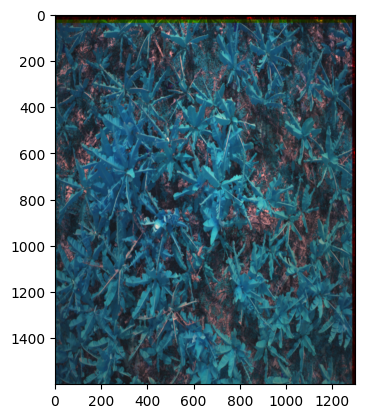

In [78]:
plt.imshow(imgrgb)

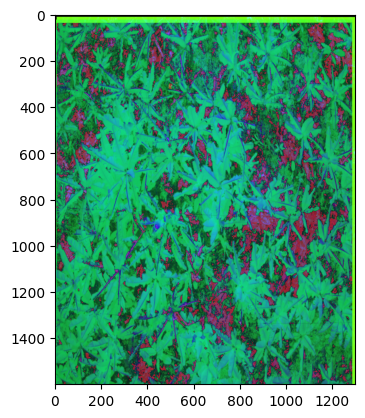

In [70]:
plt.imshow(imghsv)

In [72]:
cv2.imwrite("dji.jpg",cv2.cvtColor(imgrgb,cv2.COLOR_RGB2BGR))

True

In [82]:
imghsv

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 98, 255,  65],
        [ 98, 255,  65],
        [ 98, 255,  67],
        ...,
        [  0, 255,  30],
        [  0, 255,  28],
        [  0, 255,  30]],

       [[ 98, 255,  65],
        [ 99, 255,  67],
        [ 98, 255,  67],
        ...,
        [  0, 255,  30],
        [  0, 255,  29],
        [  0, 255,  30]],

       [[ 98, 255,  67],
        [ 98, 255,  68],
        [ 98, 255,  69],
        ...,
        [  0, 255,  30],
        [  0, 255,  30],
        [  0, 255,  31]]